In [13]:
import os
from glob import glob
import nibabel as nib
from scipy.spatial.distance import dice
import numpy as np
import itk
import SimpleITK as sitk
import scipy.ndimage
import scipy
import matplotlib.pyplot as plt
import pandas as pd
from nilearn.reporting import make_glm_report
from nilearn.glm.second_level import SecondLevelModel
from nilearn import plotting
from nilearn.glm import threshold_stats_img

In [14]:
from nilearn.plotting import plot_design_matrix
mouses_filename = os.path.join('dataset3', 'Femina3', 'femina3.csv')
mouses_csv = pd.read_csv(mouses_filename)

male = mouses_csv['sex'] == 'M'
female = mouses_csv['sex'] == 'F'
age1 = mouses_csv['age'] == '2mois'
age2 = mouses_csv['age'] == '4mois'
dki = mouses_csv['group'] == 'dki'
wt = mouses_csv['group'] == 'wt'

m_wt_2 = male * age1 * wt
f_wt_2 = female * age1 * wt
m_dk_2 = male * age1 * dki
f_dk_2 = female * age1* dki

m_wt_4 = male * age2 * wt
f_wt_4 = female * age2 * wt
m_dk_4 = male * age2 * dki
f_dk_4 = female * age2 * dki

design_matrix = pd.DataFrame(np.vstack((male, female, age1, age2, ).T,
                             columns=['m_wt_2', 'f_wt_2', 'm_dk_2', 'f_dk_2', 'm_wt_4', 'f_wt_4', 'm_dk_4', 'f_dk_4'])
ax = plot_design_matrix(design_matrix)
print(len(design_matrix))
design_matrix.to_csv("dataset3/Femina3/design_matrix.csv")

134


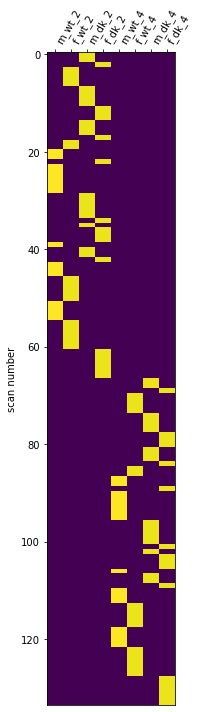

In [16]:
design_matrix = pd.DataFrame(np.vstack((m_wt_2, f_wt_2, m_dk_2, f_dk_2, m_wt_4, f_wt_4, m_dk_4, f_dk_4)).T,
                             columns=['m_wt_2', 'f_wt_2', 'm_dk_2', 'f_dk_2', 'm_wt_4', 'f_wt_4', 'm_dk_4', 'f_dk_4'])
ax = plot_design_matrix(design_matrix)
print(len(design_matrix))
design_matrix.to_csv("dataset3/Femina3/design_matrix.csv")

In [9]:
thresholds_dict = { 
                #'fdr005': ('fdr', 0.05),
                'fpr001': ('fpr', 0.01), 
                #'fpr0001': ('fpr', 0.001),  
                #'fpr0005': ('fpr', 0.005),
            }

contrasts_dict = {
    'a_2m': [1, -1, 0, 0, 0, 0, 0, 0],
    'a_4m': [0, 0, 0, 0, 1, -1, 0, 0],
    'b_2m': [0, 1, 0, -1, 0, 0, 0, 0],
    'b_4m': [0, 0, 0, 0, 0, 1, 0, -1],
    'c_2m': [1, 0, -1, 0, 0, 0, 0, 0],
    'c_4m': [0, 0, 0, 0, 1, 0, -1, 0],
    'd_2m': [0, 0, 1, -1, 0, 0, 0, 0],
    'd_4m': [0, 0, 0, 0, 0, 0, 1, -1],
    
    #'age'    : [-1, -1, -1, -1, 1, 1, 1, 1],
    #'age-M'  : [-1, 0, -1, 0, 1, 0, 1, 0],
    #'age-F'  : [0, -1, 0, -1, 0, 1, 0, 1],
    #'age-wt' : [-1, -1, 0, 0, 1, 1, 0, 0],
    #'age-dki': [0, 0, -1, -1, 0, 0, 1, 1],    
    #'sex'    : [1, -1, 1, -1, 1, -1, 1, -1],
    #'sex-2m' : [1, -1, 1, -1, 0, 0, 0, 0],
    #'sex-4m' : [0, 0, 0, 0, 1, -1, 1, -1],
    #'sex-wt' : [1, -1, 0, 0, 1, -1, 0, 0],
    #'sex-dki': [0, 0, 1, -1, 0, 0, 1, -1],
    #'group'  : [1, 1, -1, -1, 1, 1, -1, -1],
    #'group-M'  : [1, 0, -1, 0, 1, 0, -1, 0],
    #'group-F'  : [0, 1, 0, -1, 0, 1, 0, -1],
    #'group-2m'  : [1, 1, -1, -1, 0, 0, 0, 0],
    #'group-4m'  : [0, 0, 0, 0, 1, 1, -1, -1],    
}

In [11]:
# Il faut supprimer 2mois_7436 ! Fait à la main

In [10]:
atlas_mri = os.path.join('dataset3', 'Atlas', 'P56_Atlas_128_norm_id.nii.gz')
mask_img = nib.load(os.path.join('dataset3', 'Atlas', 'P56_Annotation_128_norm_id_mask.nii.gz'))
outfolders = [
            'test',
]
for outfolder in outfolders:
    log_filenames = sorted(glob(os.path.join('output', 'Femina3', outfolder, 'Log10Jacobian_Deformable', "*.nii.gz")))
    #print(log_filenames)
    second_level_model = SecondLevelModel(smoothing_fwhm=4.0, mask_img=mask_img)
    second_level_model.fit(log_filenames,
                           design_matrix=design_matrix)
    
    for heights, values in thresholds_dict.items():
        report = make_glm_report(model=second_level_model,
                                     contrasts=contrasts_dict,
                                     bg_img=atlas_mri,
                                     height_control=values[0],
                                     alpha=values[1],
                                     display_mode='y'
                                     )
        report.save_as_html(os.path.join('output', 'Femina3', outfolder, 'Reports-Deformable', 'report_deformable_femina3_' + str(heights) + '.html'))
    
    for k,v in contrasts_dict.items(): 
        z_map = second_level_model.compute_contrast(second_level_contrast=v, output_type='z_score')
        for heights, values in thresholds_dict.items():
            threshold_mask, threshold = threshold_stats_img(z_map, alpha=values[1], height_control=values[0])    
            nib.save(threshold_mask, os.path.join('output', 'Femina3', outfolder, 'Reports-Deformable', str(k) + '_' + str(heights) + '.nii.gz'))